In [1]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
from numpy.polynomial.legendre import Legendre
from scipy.special import legendre # legendre(n)用于生成n阶勒让德多项式。
# 勒让德多项式是一类正交多项式，常用于数值分析、物理问题的求解以及函数逼近。
from scipy.integrate import fixed_quad 
#fixed_quad是一种使用固定阶数的高斯求积法进行数值积分的函数。
#它对于积分光滑函数非常精确和高效。
from scipy.linalg import eig
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
# eig：用于计算一般方阵的特征值和特征向量。
# eigh：用于计算厄米特（Hermitian）矩阵或实对称矩阵的特征值和特征向量。
# eigsh：用于计算大型稀疏对称矩阵的特征值。
import warnings
from res_tool import compute_koopman_matrices,compute_edmd_eigenpairs,compute_residual
from res_tool import plot_clustered_kuramoto

In [2]:
def monte_carlo_integration_data(data, n_points=30):
    """
    使用蒙特卡洛方法处理轨迹数据
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    
    Returns:
    processed_data: 处理后的数据 (n_points x 4)
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 生成随机时间点
    random_indices = np.random.uniform(0, n_original-1, n_points)
    
    processed_data = []
    for t in random_indices:
        idx_low = int(np.floor(t))
        idx_high = min(idx_low + 1, n_original - 1)
        frac = t - idx_low
        
        # 线性插值
        interpolated_point = (1 - frac) * data[idx_low] + frac * data[idx_high]
        processed_data.append(interpolated_point)
    
    # 蒙特卡洛方法的权重均匀分布
    weights = np.ones(n_points) / n_points
    
    return np.array(processed_data), weights, random_indices

def gauss_legendre_integration_data(data, n_points=20):
    """
    使用高斯-勒让德方法处理轨迹数据
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    
    Returns:
    processed_data: 处理后的数据 (n_points x 4)
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 获取高斯-勒让德节点和权重
    nodes, weights = np.polynomial.legendre.leggauss(n_points)
    
    # 将节点从[-1,1]映射到[0, n_original-1]
    mapped_nodes = 0.5 * (n_original - 1) * (nodes + 1)
    
    processed_data = []
    for t in mapped_nodes:
        idx_low = int(np.floor(t))
        idx_high = min(idx_low + 1, n_original - 1)
        frac = t - idx_low
        
        # 线性插值
        interpolated_point = (1 - frac) * data[idx_low] + frac * data[idx_high]
        processed_data.append(interpolated_point)
    
    # 调整权重以适应新的区间并归一化
    weights = weights * 0.5 * (n_original - 1)
    weights = weights / np.sum(weights)  # 归一化
    
    return np.array(processed_data), weights, mapped_nodes

def trapezoidal_integration_data(data, n_points=25):
    """
    使用梯形法则思路处理轨迹数据（均匀采样）
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    
    Returns:
    processed_data: 处理后的数据
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 均匀采样指定数量的点
    indices = np.linspace(0, n_original-1, n_points, dtype=int)
    processed_data = data[indices]
    
    # 梯形法则的权重（端点权重为0.5，中间为1）
    weights = np.ones(n_points)
    weights[0] = 0.5
    weights[-1] = 0.5
    
    # 归一化权重
    weights = weights / np.sum(weights)
    
    return processed_data, weights, indices.astype(float)

def riemann_sum_integration_data(data, n_points=25, method='midpoint'):
    """
    使用黎曼和思路处理轨迹数据
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    method: 'left', 'right', 'midpoint'
    
    Returns:
    processed_data: 处理后的数据
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 计算每个区间的长度
    interval_length = n_original / n_points
    
    processed_data = []
    indices = []
    
    for i in range(n_points):
        start_idx = i * interval_length
        end_idx = min((i + 1) * interval_length, n_original)
        
        if method == 'left':
            # 使用区间左端点
            point_idx = start_idx
        elif method == 'right':
            # 使用区间右端点
            point_idx = min(end_idx - 1, n_original - 1)
        elif method == 'midpoint':
            # 使用区间中点
            point_idx = (start_idx + end_idx) / 2
        
        # 找到最近的整数索引进行插值
        idx_low = int(np.floor(point_idx))
        idx_high = min(idx_low + 1, n_original - 1)
        frac = point_idx - idx_low
        
        # 线性插值
        interpolated_point = (1 - frac) * data[idx_low] + frac * data[idx_high]
        processed_data.append(interpolated_point)
        indices.append(point_idx)
    
    # 黎曼和的权重均匀分布
    weights = np.ones(n_points) / n_points
    
    return np.array(processed_data), weights, np.array(indices)

In [3]:
def koop_pseudo_spec(G, A, L, z_pts, **kwargs):
    """
    计算K的伪谱
    
    Parameters:
    G: Gram矩阵<psi_j, psi_i>
    A: 第一个Galerkin矩阵 <K psi_j, psi_i>
    L: 第二个Galerkin矩阵 <K psi_j, K psi_i>
    z_pts: 复数点向量，用于计算伪谱
    
    Optional:
    reg_param: G的正则化参数
    
    Returns:
    RES: z_pts处的残差
    """
    # 解析可选参数
    reg_param = kwargs.get('reg_param', 1e-14)
    
    # 确保矩阵是Hermitian的
    G = (G + G.T.conj()) / 2
    L = (L + L.T.conj()) / 2
    
    # 正则化G并计算SQ矩阵
    G_reg = G + np.linalg.norm(G) * reg_param * np.eye(G.shape[0])
    w, V = eigh(G_reg)
    
    # 避免除零和负值
    w = np.maximum(w, 1e-15)
    w_sqrt = np.sqrt(1.0 / np.abs(w))
    SQ = V @ np.diag(w_sqrt) @ V.T.conj()
    
    z_pts = z_pts.flatten()
    LL = len(z_pts)
    RES = np.zeros(LL, dtype=float)
    
    if LL > 0:
        warnings.filterwarnings('ignore', category=UserWarning)
        
        for jj in range(LL):
            z = z_pts[jj]
            try:
                # 构造该z对应的矩阵
                M_z = (L - z * A.T.conj() - np.conj(z) * A + (np.abs(z)**2) * G)
                M_transformed = SQ @ M_z @ SQ
                
                # 确保矩阵是Hermitian的以用于eigvalsh
                M_transformed = (M_transformed + M_transformed.T.conj()) / 2
                
                # 使用稠密计算找到最小特征值（更稳定）
                eigvals = np.linalg.eigvalsh(M_transformed)
                min_eigval = np.min(np.real(eigvals))
                
                # 避免由于数值误差导致的负值
                RES[jj] = np.sqrt(max(0, min_eigval))
                
            except Exception as e:
                print(f"Warning: Error at z={z}: {e}")
                RES[jj] = np.nan
    
    warnings.resetwarnings()
    
    return RES

In [4]:
def plot_pseudospectra(G, A, L, step=0.05, residual_threshold=0.01, padding_ratio=0.2, fixed_range=None):
    """
    绘制伪谱图，并根据残差阈值区分可靠和虚假特征值

    Parameters:
    G, A, L: Koopman矩阵
    x_range, y_range: 绘图范围
    step: 网格步长
    residual_threshold: 算法2中的残差阈值ε
    padding_ratio: 在特征值范围基础上添加的边距比例
    fixed_range: 如果提供，则使用固定的绘图范围 (x_min, x_max, y_min, y_max)
    """
    # 1. 计算EDMD特征对 (算法2步骤2)
    eigenvalues, eigenvectors = compute_edmd_eigenpairs(G, A, L)
    # 特征向量在矩阵eigenvectors的列中

    # 2. 为每个特征对计算残差 (算法2步骤3的逻辑)
    residuals = []
    reliable_indices = []
    spurious_indices = []

    for i in range(len(eigenvalues)):
        lambda_i = eigenvalues[i]
        g_i = eigenvectors[:, i]
        res_i = compute_residual(lambda_i, g_i, G, A, L)
        residuals.append(res_i)

        if res_i <= residual_threshold:
            reliable_indices.append(i)
        else:
            spurious_indices.append(i)

    print(f"总特征值数量: {len(eigenvalues)}")
    print(f"可靠特征值数量 (res <= {residual_threshold}): {len(reliable_indices),reliable_indices}")
    print(f"虚假特征值数量 (res > {residual_threshold}): {len(spurious_indices)}")

    # 3. 确定绘图范围
    if fixed_range is not None:
        # 使用固定的绘图范围
        x_range = (fixed_range[0], fixed_range[1])
        y_range = (fixed_range[2], fixed_range[3])
    else:
        # 自适应范围：基于所有特征值的分布
        real_parts = np.real(eigenvalues)
        imag_parts = np.imag(eigenvalues)
        
        # 计算特征值的范围
        real_min, real_max = np.min(real_parts), np.max(real_parts)
        imag_min, imag_max = np.min(imag_parts), np.max(imag_parts)
        
        # 使用相同的范围，保持纵横比一致
        overall_min = min(real_min, imag_min)
        overall_max = max(real_max, imag_max)
        overall_range = overall_max - overall_min
        
        # 如果范围太小（如所有特征值都集中在一点），设置最小范围
        if overall_range < 0.1:
            overall_range = 1.0
            center = (overall_min + overall_max) / 2
            overall_min = center - 0.5
            overall_max = center + 0.5
        
        # 添加边距
        padding = overall_range * padding_ratio
        x_range = (overall_min - padding, overall_max + padding)
        y_range = (overall_min - padding, overall_max + padding)
    
    # 3. 计算伪谱网格（算法3/原有伪谱计算逻辑）
    x_pts = np.arange(x_range[0], x_range[1] + step, step)
    y_pts = np.arange(y_range[0], y_range[1] + step, step)
    X_grid, Y_grid = np.meshgrid(x_pts, y_pts)
    z_pts = X_grid + 1j * Y_grid
    z_flat = z_pts.flatten()

    RES = koop_pseudo_spec(G, A, L, z_flat)
    RES = RES.reshape(z_pts.shape)
    RES = np.nan_to_num(RES, nan=np.max(RES[~np.isnan(RES)]))

    # 4. 绘图
    plt.figure(figsize=(8, 8))

    # 伪谱等高线
    levels = [0.001, 0.01, 0.1, 0.3]
    contour = plt.contour(X_grid, Y_grid, np.real(RES), levels=levels,
                         colors='black', linewidths=2)
    plt.clabel(contour, inline=True, fontsize=11, fmt='%.3f')

    # 绘制特征值
    # 可靠特征值 (残差小) - 蓝色十字
    reliable_eigs = eigenvalues[reliable_indices]
    plt.plot(np.real(reliable_eigs), np.imag(reliable_eigs), 'x',
             markersize=8, color='blue', markeredgewidth=2,
             label=f'Reliable eigenvalues (res $\leq$ {residual_threshold})')

    # 虚假特征值 (残差大) - 洋红点
    spurious_eigs = eigenvalues[spurious_indices]
    plt.plot(np.real(spurious_eigs), np.imag(spurious_eigs), '.',
             markersize=10, color='magenta',
             label='Spurious eigenvalues')

    # 格式化
    plt.gca().set_aspect('equal')
    plt.xlabel('Real', fontsize=14)
    plt.ylabel('Imaginary', fontsize=14)
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.title(f'Pseudospectrum and Eigenvalues (Residual Threshold = {residual_threshold})', fontsize=14)
    plt.tight_layout()
    plt.show()
    return eigenvalues, residuals, reliable_indices

In [31]:
def plot_quadrature_errors(kp):
    """绘制求积误差图 - 修复参考线和主曲线问题"""
    N=12
    data_noisy, K_matrix = plot_clustered_kuramoto(N=N, n_clusters=2, K_intra=5, K_inter=0.1,noise=0.01,T=100)
    #data_noisy = generate_sir_data(M=150)
    X,W,indices = gauss_legendre_integration_data(data_noisy, n_points=1000)
    #mc_data, mc_weights, mc_indices = monte_carlo_integration_data(data_noisy, n_points=1000)
    #gl_data, gl_weights, gl_indices = gauss_legendre_integration_data(data_noisy, n_points=1000)
    #ri_data, ri_weights, ri_indices =  riemann_sum_integration_data(data_noisy, n_points=1000)
    #ti_data, ti_weights, ti_indices = trapezoidal_integration_data(data_noisy, n_points=1000)
    Y = data_noisy[np.minimum(indices + 1, len(data_noisy) - 1).astype(int)]
    XH = kp.transform(X)
    YH = kp.transform(Y)
    G, test_ref, L = compute_koopman_matrices(XH, W, YH)

    # 样本大小向量 - 确保唯一性
    Mvec = np.unique(np.round(10**(np.arange(0.2, 4.05, 0.05))).astype(int))
    Mvec = Mvec[Mvec != 200]  # 移除200如果存在
    Mvec = np.append(Mvec, 201)  # 添加201
    Mvec = np.sort(Mvec)  # 确保排序
    
    methods = ['monte_carlo', 'gauss_legendre', 'trapezoidal', 'riemann_sum']
    me = len(methods)
    E = np.zeros((len(Mvec), me))
    method_functions = {
        'monte_carlo': monte_carlo_integration_data,
        'gauss_legendre': gauss_legendre_integration_data,
        'trapezoidal': trapezoidal_integration_data,
        'riemann_sum': riemann_sum_integration_data}
    
    #data_noisyN = generate_sir_data(M=150)
    for ct, j in enumerate(Mvec):
        for k in range(me):
            method_name = methods[k]
            method_func = method_functions[method_name]
            XX,WW,indicesN = method_func(data_noisy, n_points=j)
            YY = data_noisy[np.minimum(indicesN + 1, len(data_noisy) - 1).astype(int)]
            XHH = kp.transform(XX)
            YHH = kp.transform(YY)
            A_mat = compute_koopman_matrices(XHH,WW,YHH)[1]
            E[ct, k] = np.max(np.abs(test_ref - A_mat))
    
    # 绘制结果
    plt.figure(figsize=(8, 6))
    
    # 主曲线 - 确保每条线只绘制一次
    #methods = ['Monte Carlo', 'Gauss--Legendre', 'Trapezoidal', 'Riemann sum']
    colors = ['purple', 'blue', 'red', 'orange']
    
    for k in range(me):
        # 过滤掉NaN值
        valid_mask = ~np.isnan(E[:, k]) & (E[:, k] > 0)
        if np.any(valid_mask):
            plt.loglog(Mvec[valid_mask], E[valid_mask, k], linewidth=2, 
                      label=methods[k], color=colors[k])
    
    # 参考线
    mask = Mvec >= 20  # 扩大范围
    
    # 调整比例常数以避免重叠
    plt.loglog(Mvec[mask], 10 / Mvec[mask], 'k:', linewidth=2, 
               alpha=0.7, label=r'$O(1/M)$')
    plt.loglog(Mvec[mask], 200 / Mvec[mask]**2, 'k--', linewidth=2, 
               alpha=0.7, label=r'$O(1/M^2)$')
    plt.loglog(Mvec[mask], 5 / np.sqrt(Mvec[mask]), 'k-.', linewidth=2, 
               alpha=0.7, label=r'$O(1/\sqrt{M})$')
    
    # 格式化
    plt.legend(fontsize=12, loc='lower right', framealpha=0.7)
    plt.xlabel('Sample size M', fontsize=14)
    plt.ylabel('Max Error', fontsize=14)
    plt.xlim(1, 10000)
    #plt.ylim(1e-15, 10)
    plt.grid(True, alpha=0.3, which='both')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Quadrature Errors Convergence', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return E

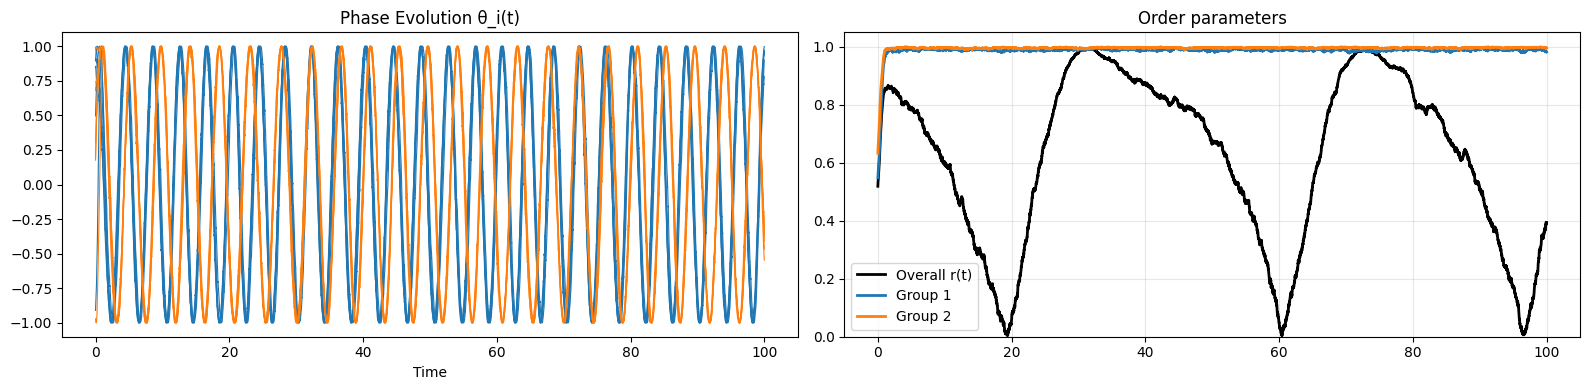

In [6]:
N=12
data_noisy, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=2,  # 团数
    K_intra=5,   # 团内耦合
    K_inter=0.1,   # 团间耦合
    noise=0.01,
    T=100
)

In [7]:
#多项式函数
kppl = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=1,interaction_only=True)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),#,truncation_param=20
)
# Fit the pipeline
kppl.fit(
    data_noisy,
    n_inputs=0
)
errorpl = -kppl.score(data_noisy)
errorpl

0.08168566465241411

In [18]:
X,W,indices = gauss_legendre_integration_data(data_noisy, n_points=10000)
#mc_data, mc_weights, mc_indices = monte_carlo_integration_data(data_noisy, n_points=1000)
#gl_data, gl_weights, gl_indices = gauss_legendre_integration_data(data_noisy, n_points=1000)
#ri_data, ri_weights, ri_indices =  riemann_sum_integration_data(data_noisy, n_points=1000)
#ti_data, ti_weights, ti_indices = trapezoidal_integration_data(data_noisy, n_points=1000)

In [19]:
Y = data_noisy[np.minimum(indices + 1, len(data_noisy) - 1).astype(int)]
XH = kppl.transform(X)
YH = kppl.transform(Y)
G, A, L = compute_koopman_matrices(XH, W, YH)

In [20]:
XH.shape

(10000, 24)

总特征值数量: 24
可靠特征值数量 (res <= 0.01): (4, [10, 11, 12, 13])
虚假特征值数量 (res > 0.01): 20


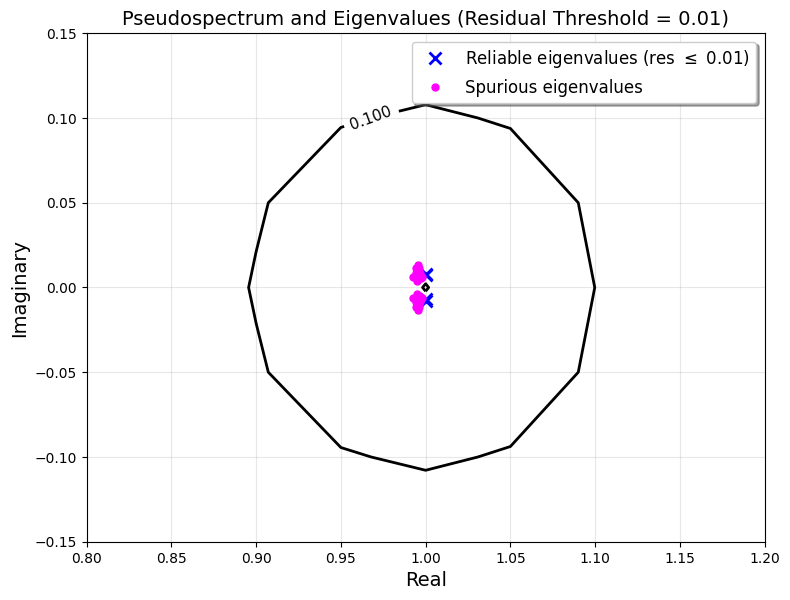

In [26]:
# 计算伪谱
eigenvalues, residuals, reliable_indices = plot_pseudospectra(G, A, L, residual_threshold=0.01,fixed_range=(0.8,1.2,-0.15,0.15))

In [27]:
residuals

[0.06933115032955746,
 0.06933115032960532,
 0.13193534470684182,
 0.1319353447068985,
 0.1135753970888006,
 0.1135753970888006,
 0.09925676594223617,
 0.09925676594222305,
 0.08056175024379439,
 0.08056175024379439,
 0.00831330710189638,
 0.008313307101896384,
 0.006282795253751003,
 0.00628279525374909,
 0.11317943882325507,
 0.11317943882320547,
 0.1299441099914877,
 0.12994410999140046,
 0.13053526521132133,
 0.13053526521133219,
 0.1070684902280375,
 0.10706849022800506,
 0.11427780428986754,
 0.11427780428984789]

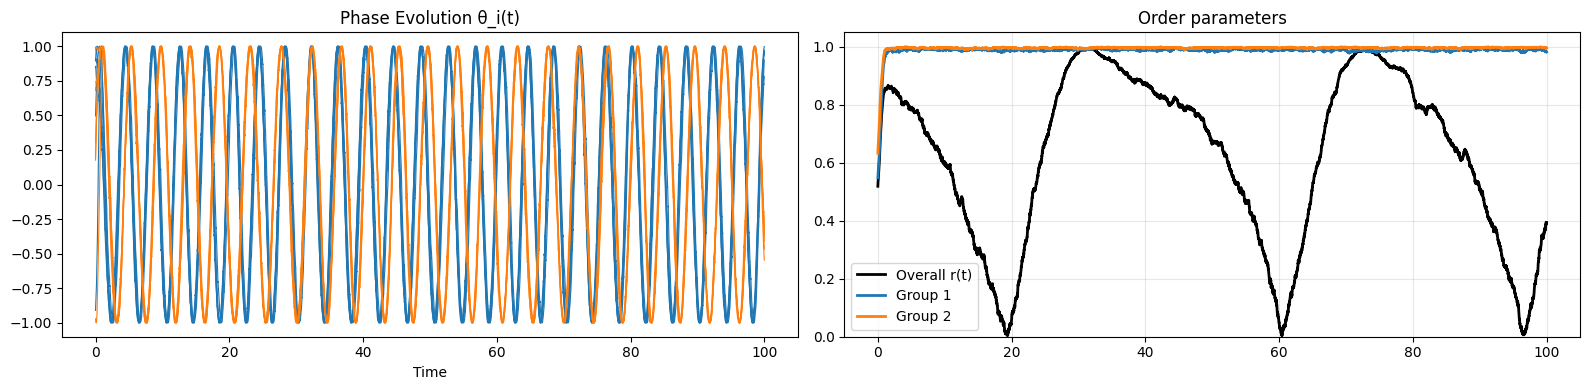

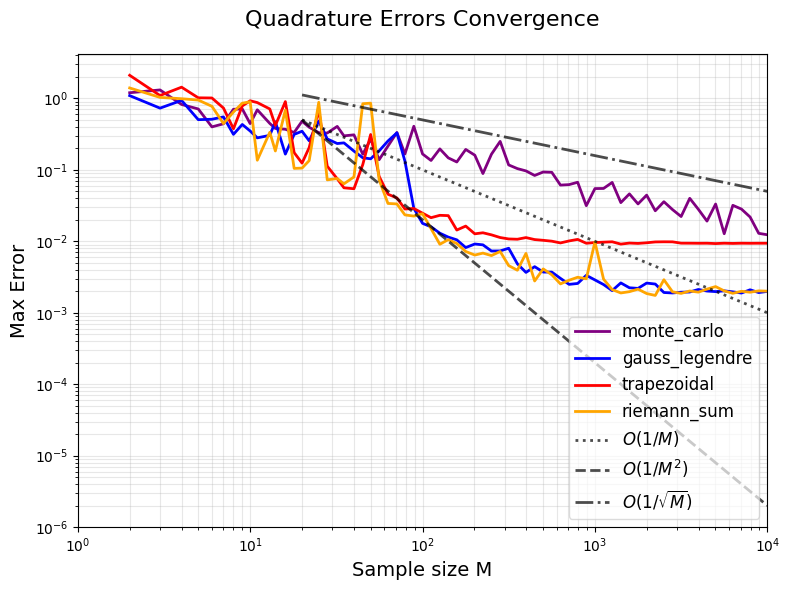

array([[1.19983664e+00, 1.09333327e+00, 2.10487440e+00, 1.39936930e+00],
       [1.31304215e+00, 7.30273093e-01, 1.09661973e+00, 1.03213081e+00],
       [8.22437119e-01, 9.37043168e-01, 1.43541604e+00, 9.89072432e-01],
       [7.11014615e-01, 5.03729220e-01, 1.01867090e+00, 9.47867164e-01],
       [3.99279597e-01, 5.10618012e-01, 1.01325431e+00, 7.74843625e-01],
       [4.40914572e-01, 5.50562332e-01, 7.32767925e-01, 4.44294586e-01],
       [7.04018200e-01, 3.13875596e-01, 3.75466498e-01, 6.44667907e-01],
       [7.11957154e-01, 4.31579699e-01, 7.84462475e-01, 8.56996185e-01],
       [4.44000690e-01, 3.49746539e-01, 9.26125400e-01, 8.94995459e-01],
       [6.92336503e-01, 2.80360010e-01, 8.73766017e-01, 1.36373435e-01],
       [4.46098192e-01, 3.03894240e-01, 7.11448356e-01, 3.35365135e-01],
       [3.79840705e-01, 4.70941720e-01, 4.17155788e-01, 1.83753438e-01],
       [3.69810031e-01, 1.66044062e-01, 9.01461916e-01, 6.85381358e-01],
       [3.33726802e-01, 3.13707990e-01, 1.74159753e

In [32]:
plot_quadrature_errors(kppl)